## Importing Library

In [10]:
# Importing necessary libraries
import pandas as pd
import numpy as np

# Used for normalizing the dataset
from sklearn.preprocessing import MinMaxScaler

## Importing Dataset

In [11]:
# Path to the dataframe
data_path = '../SavedData/simulated_transaction_2024.csv'

# Set the file path to a dataframe
biz_df = pd.read_csv(data_path)

## Business Names

In [12]:
business_names = list(biz_df['Third Party Name'].dropna().unique())

## Building Business Fingerprints

In [13]:
# Things that determine types of businesses:
# - Median size of payment
# - Payment ranges
# - Total number of payments
# - Number of unique payment days
# - Number of unique payment times

### Cleaninng the DataFrame columns

In [14]:
# Only include business names no 'nan' values
biz_tx_df = biz_df[biz_df['Third Party Name'].isin(business_names)]

# Exclude salary and refund payments
biz_tx_df = biz_tx_df[biz_tx_df['Amount'] < 0]

# Make Amount column positive
biz_tx_df['Amount'] = biz_tx_df['Amount'] * -1

# Remove capitalization and spaces from 'Third Party Name' column
biz_tx_df['Third Party Name'] = biz_tx_df['Third Party Name'].str.lower().str.replace(' ', '')

### Calculating the different identifiers

In [15]:
biz_tx_median = biz_tx_df.groupby('Third Party Name')['Amount'].median().rename('Median')
biz_tx_iqr = biz_tx_df.groupby('Third Party Name')['Amount'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25)).rename('IQR')
biz_tx_count = biz_tx_df.groupby('Third Party Name')['Amount'].count().rename('Count')
biz_tx_unique_days = biz_tx_df.groupby('Third Party Name')['Date'].nunique().rename('Unique Days Count')
biz_tx_unique_timestamps = biz_tx_df.groupby('Third Party Name')['Timestamp'].nunique().rename('Unique Timestamps Count')

In [16]:
biz_tx_id_df = pd.concat([biz_tx_median, biz_tx_iqr, biz_tx_count, biz_tx_unique_days, biz_tx_unique_timestamps], axis=1).reset_index()

In [17]:
biz_tx_id_df_lc = biz_tx_id_df[biz_tx_id_df['Count'] <= 3]
biz_tx_id_df = biz_tx_id_df[biz_tx_id_df['Count'] > 3]

### Normalizing the DataFrame

In [18]:
# Columns for normalization
cols = ['Median', 'IQR', 'Count', 'Unique Days Count', 'Unique Timestamps Count']

# Initialize StandardScaler
scaler = MinMaxScaler()

# Fit scalar to df and transform the df
norm_biz_tx_id_df = biz_tx_id_df.copy()
norm_biz_tx_id_df[cols] = scaler.fit_transform(biz_tx_id_df[cols])

## Building the Clusters

### Finding the Correct Number of Clusters using an elbow graph

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-p

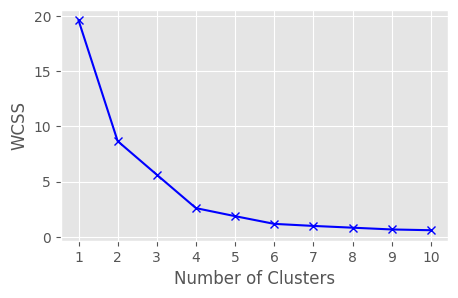

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# WCSS for each number of clusters
sse = []

# Range of possible clusters
cluster_range = range(1, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(norm_biz_tx_id_df[cols])
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(5, 3))
plt.plot(cluster_range, sse, marker='x', color='blue', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(cluster_range)
plt.show()

### Creating Kmeans with the right number of clusters

In [21]:
# Define the number of clusters
n_clusters = 4

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Fit KMeans using the numeric columns
kmeans.fit(norm_biz_tx_id_df[cols])

# Assign the cluster labels to the DataFrame
norm_biz_tx_id_df['Cluster'] = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Setting Industries

In [22]:
# Industry Mapping
industry_categories = {
    'topshop': 'apparel',
    'selfridges': 'apparel',
    'matalan': 'apparel',
    'revella': 'apparel',
    'looselyfitted': 'apparel',
    'fatface': 'apparel',
    'fittedstitch': 'apparel',
    'blackwells': 'books',
    'foyles': 'books',
    'ayarnstory': 'crafts',
    'brilliantbrushes': 'crafts',
    'cassart': 'crafts',
    'craftastic': 'crafts',
    'fivesensesart': 'crafts',
    'hobbylobby': 'crafts',
    'stitchbystitch': 'crafts',
    'theworks': 'crafts',
    'wool': 'crafts',
    'hobbycraft': 'crafts',
    'coffee#1': 'cafe',
    'costacoffee': 'cafe',
    'starbucks': 'cafe',
    'mamas&papas': 'children',
    'mothercare': 'children',
    'deliveroo': 'delivery',
    'justeat': 'delivery',
    'cex': 'electronics',
    'gamestation': 'electronics',
    'kewhouse': 'education',
    'lavenderprimary': 'education',
    'halifax': 'finance',
    'lbg': 'finance',
    'sainsbury': 'grocery',
    'sainsburylocal': 'grocery',
    'tesco': 'grocery',
    'cooplocal': 'grocery',
    'acutabove': 'hair and beauty',
    'barbieeboutique': 'hair and beauty',
    'remedypluscare': 'healthcare',
    'specsavers': 'healthcare',
    'universitycollegehospital': 'healthcare',
    'visionexpress': 'healthcare',
    'collectorcave': 'niche media',
    'hmv': 'niche media',
    'gapkids': 'niche apparel',
    'happydayshome': 'niche apparel',
    'millets': 'niche apparel',
    'mountainwarehouse': 'niche apparel',
    'northface': 'niche apparel',
    'head': 'niche sports',
    'rugbyfields': 'niche sports',
    'amazon': 'online shopping',
    'etsy': 'online shopping',
    'petscorner': 'pets',
    'lloydspharmacy': 'pharmacy',
    'boots': 'pharmacy',
    'kingsarms': 'pubs',
    'rose&crown': 'pubs',
    'thecrown': 'pubs',
    'frankie&bennies': 'restaurants',
    'grandunionbjj': 'sports',
    'jdsports': 'sports',
    'reebok': 'sports',
    'sportsdirect': 'sports',
    'blizzard': 'subscription',
    'disney': 'subscription',
    'mojangstudios': 'subscription',
    'netflix': 'subscription',
    'puregym': 'subscription',
    'squareonix': 'subscription',
    'xbox': 'subscription',
    'townhigh': 'other',
    'victoriapark': 'other'
}

## Graphing the Results

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data = norm_biz_tx_id_df[['Median', 'IQR', 'Count', 'Unique Days Count', 'Unique Timestamps Count']]
clusters = norm_biz_tx_id_df['Cluster']
labels = norm_biz_tx_id_df['Third Party Name']
reduced_data = pca.fit_transform(data)

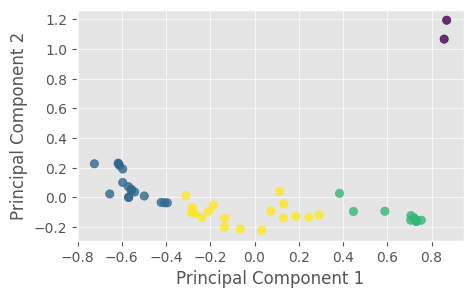

In [27]:
# Create a scatter plot
plt.style.use('ggplot')

plt.figure(figsize=(5, 3))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.8)
plt.grid(True, color='white', linestyle='-', linewidth=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()